## Price Optimization example using DQL in RLlib
This first code cell is a little magic to install Ray properly, due to hardcoded limitations in TensorFlow.

# QUESTION:
Must this **run  twice** to restart the kernel? FWIW, some of the transformer Colab notebook examples had suggested that. Running this cell only once tends to result in errors later on Colab.



---



In [0]:
!pip uninstall -y -q pyarrow
!pip install -q ray[debug]

try:
  %tensorflow_version 2.x
except Exception:
  pass

# A hack to force the runtime to restart, needed to include the above dependencies.
import os
os._exit(0)

## Prepare to run a DQN model in RLlib

In [0]:
# the `lz4` library sometimes shows as a warning / not installed on Google Colab
!pip install lz4

import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

def train_dqn (trainer, num_iter=50):
    reward_history = []

    for i in range(num_iter):
        result = trainer.train()
        max_reward = result["episode_reward_max"]
        reward_history.append(max_reward)
        print("iter {}: max reward: {:.2f}".format(i, max_reward))
        #print(pretty_print(result))

    return reward_history

## CartPole
First we'll run this with `CartPole-v0` which is a relatively simple and quick example, to examine the RLlib features involved. For more details about this problem, see the tutorial [*Cartpole - Introduction to Reinforcement Learning (DQN - Deep Q-Learning)*](https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288) by [Greg Surma](https://twitter.com/GSurma).

In [0]:
ray.shutdown()
ray.init()

trainer = dqn.DQNTrainer(env="CartPole-v0", config={"eager": False})
reward_history = train_dqn(trainer, num_iter=5)
print(reward_history)

2020-02-18 05:28:27,942	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-18 05:28:27,947	INFO resource_spec.py:212 -- Starting Ray with 6.01 GiB memory available for workers and up to 3.01 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-18 05:28:28,294	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-02-18 05:28:28,997	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-18 05:28:29,022	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('W

iter 0: max reward: 76.00
iter 1: max reward: 76.00
iter 2: max reward: 102.00
iter 3: max reward: 153.00
iter 4: max reward: 167.00
[76.0, 76.0, 102.0, 153.0, 167.0]


The history of `max_reward` shows this model edge toward a number higher than `150` -- which is good, since the [*solution*](https://gym.openai.com/envs/CartPole-v0/) for `CartPole-v0` is to get an average reward of `195.0` over a hundred consecutive trials.

# QUESTION:
How do we inspect a trained policy?

The Ray/RLlib docs show examples of dumping out the model variables, although frankly there's almost no attention paid to connecting the results with any kind of stated goal.

The risk is that many people will walk away cynically: "They showed us some numbers, then calculated for a long while, then showed us other numbers -- which apparanetly were a big deal, because research. Or something."

Ideally, we could plot or otherwise analyze the resulting `policy` and see how the CartPole is being adjusted. That really isn't clear anywhere from the docs.

Also, the docs suggest to "Run a forward pass to get base model output" but even in this simple case of CartPole, what does that mean?


---

Now that we've trained a model, we can look at its resulting policy…

In [0]:
import pprint

policy = trainer.get_policy()
model = policy.model

pprint.pprint(model.variables())
pprint.pprint(model.value_function())

[<tf.Variable 'default_policy/fc_1/kernel:0' shape=(4, 256) dtype=float32>,
 <tf.Variable 'default_policy/fc_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/kernel:0' shape=(256, 256) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/value_out/kernel:0' shape=(256, 1) dtype=float32>,
 <tf.Variable 'default_policy/value_out/bias:0' shape=(1,) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_0/kernel:0' shape=(256, 256) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_0/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/dense/kernel:0' shape=(256, 2) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/dense/bias:0' shape=(2,) dtype=float32>,
 <tf.Variable 'default_policy/q_func/state_value/dense_1/kernel:0' shape=(256, 256) dtype=float32>,
 <tf.Variable 'default_policy/q_func/state_value/dense_1

## Set up the Pricing Polity Optimization environment simulator
Now let's try a more complex reinforcement learning problem. This is a *pricing policy optimization* problem, based on the tutorial in [*Deep reinforcement learning for supply chain and price optimization*](https://blog.griddynamics.com/deep-reinforcement-learning-for-supply-chain-and-price-optimization/) by [Ilya Katsov](https://twitter.com/ikatsov).

In [0]:
def plus (x):
    return 0 if x < 0 else x

def minus (x):
    return 0 if x > 0 else -x

def shock (x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t (p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t (p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total (p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## partial bindings for readability
def profit_t_response (p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response (p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Baseline Solution
Find a baseline solution based on the *optimal constant price*

In [0]:
import math
import numpy as np

price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros((len(price_grid), len(price_change_grid)))

for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f"optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}")

optimal price is 170, achieved profit is 2352000.0


## Visualize price-demand functions
Temporarily, for reference: we could nix this and just point people to the original article for the visualization. In the very least, let's be sure to replace the `matplotlib` kludge and get better visualizations.

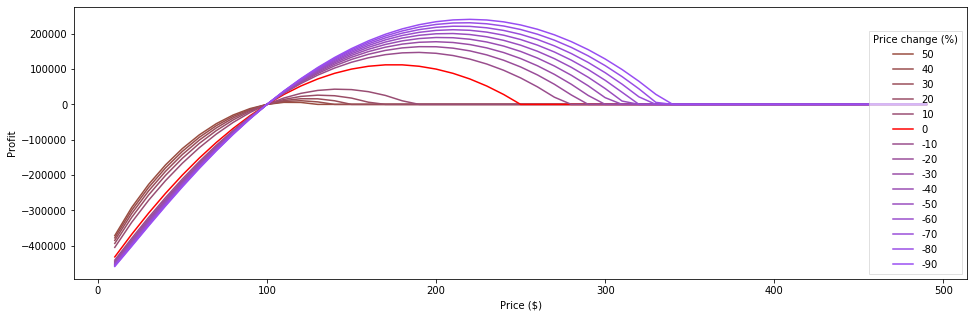

In [0]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'red'
    else:
        color = (0.6, 0.3, price_change_grid[i] / 2.0)

    plt.plot(price_grid, profit_map[:, i], c=color)
  
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1 - price_change_grid) * 100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)

## Wrap the simulation using Gym
Next we'll wrap the price optimization simulation as a [Gym](https://gym.openai.com/) environment for the `DQNTrainer` to use…

In [0]:
import gym
from gym.spaces import Discrete, Box

def env_intial_state ():
    return np.repeat(0, 2*T)

def env_step (t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1])
    return next_state, reward

class HiLoPricingEnv (gym.Env):
    def __init__ (self, config):
        self.reset()
        self.action_space = Discrete(len(price_grid))
        self.observation_space = Box(0, 10000, shape=(2*T, ), dtype=np.float32)

    def reset (self):
        self.state = env_intial_state()
        self.t = 0
        return self.state

    def step (self, action):
        next_state, reward = env_step(self.t, self.state, action)
        self.t += 1
        self.state = next_state
        return next_state, reward, self.t == T - 1, {}

# QUESTION:
The Ray docs describe (vaguely, buried in a method PyDoc string) an external environment as having an *action space* and an *observation space*. Ideally, we'd break down the `HiLoPricingEnv` example to illustrate that. Will need better info first.

BTW, trying to lookup the API reference for `ray.rllib.agents.dqn.DQNTrainer()` was **effing painful** -- either in the docs or the code.  Ideally we'd use that as a way to explore the `HiLoPricingEnv` environment as one of its parameters.



---



Now here's the long-running portion. This pricing optimization problem takes about 90 seconds per iteration on a Colab free instance with no GPU.

In [0]:
ray.shutdown()
ray.init()

config = dqn.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["lr"] = 0.002
config["gamma"] = 0.80
config["train_batch_size"] = 256
config["buffer_size"] = 10000
config["timesteps_per_iteration"] = 5000
config["hiddens"] = [128, 128, 128]
config["exploration_final_eps"] = 0.01

trainer = dqn.DQNTrainer(config, HiLoPricingEnv)
reward_history = train_dqn(trainer, num_iter=5)

2020-02-18 05:36:43,345	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-18 05:36:43,348	INFO resource_spec.py:212 -- Starting Ray with 5.96 GiB memory available for workers and up to 3.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-18 05:36:43,716	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-18 05:36:49,886	WARNING util.py:41 -- Install gputil for GPU system monitoring.


iter 0: max reward: 1384898.62
iter 1: max reward: 2214795.09
iter 2: max reward: 2685815.88
iter 3: max reward: 2682022.56
iter 4: max reward: 2692383.24


## Let's check the results

In [0]:
print(reward_history)

[1384898.6218858943, 2214795.086645844, 2685815.8770742626, 2682022.5584791233, 2692383.238254121]


# TODO: chart to show the convergence toward a goal, plotted versus the *optimal constant price* baseline.


Converging toward a value of approximately `2700000.00` total profit is comparable with the `2352000.00` estimate from the *optimal constant price* baseline model.

# QUESTION:
How do we visualize the optimized pricing model? The baseline example above didn't show an approach that we could reuse for the RLlib results.



---



## Let's look into the details of the model…

In [0]:
policy = trainer.get_policy()
model = policy.model

pprint.pprint(model.variables())
pprint.pprint(model.value_function())

[<tf.Variable 'default_policy/fc_1/kernel:0' shape=(40, 256) dtype=float32>,
 <tf.Variable 'default_policy/fc_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/kernel:0' shape=(256, 256) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/value_out/kernel:0' shape=(256, 1) dtype=float32>,
 <tf.Variable 'default_policy/value_out/bias:0' shape=(1,) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_0/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_0/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_1/kernel:0' shape=(128, 128) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_1/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action_value/hidden_2/kernel:0' shape=(128, 128) dtype=float32>,
 <tf.Variable 'default_policy/q_func/action

In [0]:
model.base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 40)]         0                                            
__________________________________________________________________________________________________
fc_1 (Dense)                    (None, 256)          10496       observations[0][0]               
__________________________________________________________________________________________________
fc_out (Dense)                  (None, 256)          65792       fc_1[0][0]                       
__________________________________________________________________________________________________
value_out (Dense)               (None, 1)            257         fc_1[0][0]                       
Total params: 76,545
Trainable params: 76,545
Non-trainable params: 0
________________________

In [0]:
# Access the Q value model (specific to DQN)
model.q_value_head.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_out (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 128)          32896       model_out[0][0]                  
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 128)          16512       hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 128)          16512       hidden_1[0][0]                   
____________________________________________________________________________________________

In [0]:
# Access the state value model (specific to DQN)
model.state_value_head.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_out (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 66,049
Trainable params: 66,049
Non-trainable params: 0
_________________________________________________________________
